In [1]:
import numpy as np
from scipy.sparse.linalg import eigsh

from netket.graph import Hypercube
from netket.hilbert import Spin
from netket.operator import LocalOperator, spin

import matplotlib.pyplot as plt


SIDE_LENGTH = 4

At Δ=2.0 (no h_stag):    Cxx_diag = 0.43078352166587286
At Δ=2.0 (h_stag=0.05):  Cxx_diag = 0.45594341498862345


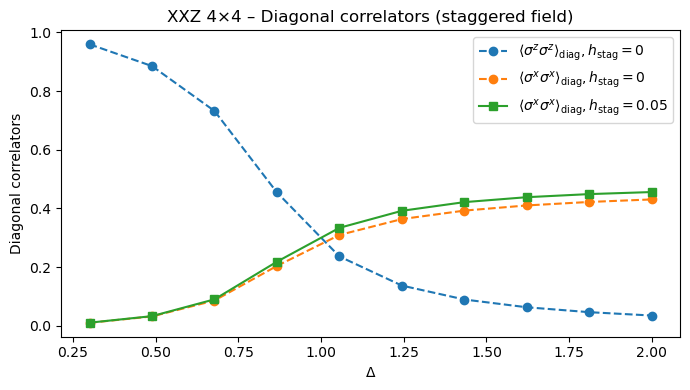

In [2]:
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

# --- system size ---
SIDE_LENGTH = 4
N = SIDE_LENGTH**2
DIM = 1 << N

# --- lattice helpers ---

def xy_to_site(x, y):
    return x + SIDE_LENGTH * y

def site_to_xy(i):
    x = i % SIDE_LENGTH
    y = i // SIDE_LENGTH
    return x, y

def nearest_neighbor_edges():
    edges = []
    L = SIDE_LENGTH
    for x in range(L):
        for y in range(L):
            a = xy_to_site(x, y)
            b = xy_to_site((x + 1) % L, y)
            edges.append((a, b))
            b = xy_to_site(x, (y + 1) % L)
            edges.append((a, b))
    return edges

def diagonal_neighbors_both():
    pairs = []
    L = SIDE_LENGTH
    for x in range(L):
        for y in range(L):
            a = xy_to_site(x, y)
            b1 = xy_to_site((x + 1) % L, (y + 1) % L)
            pairs.append((a, b1))
            b2 = xy_to_site((x + 1) % L, (y - 1) % L)
            pairs.append((a, b2))
    return pairs

EDGES = nearest_neighbor_edges()
DIAG_PAIRS = diagonal_neighbors_both()

# staggered phase factor η_i = (-1)^(x+y)
ETA = np.empty(N, dtype=int)
for i in range(N):
    x, y = site_to_xy(i)
    ETA[i] = 1 if (x + y) % 2 == 0 else -1

# --- XXZ Hamiltonian with staggered x field ---

def build_xxz_hamiltonian(delta: float, eps: float = 1e-3, hstag_x: float = 0.0):
    """
    H = sum_<ij> [ delta (σ^x_i σ^x_j + σ^y_i σ^y_j) + σ^z_i σ^z_j ]
        - eps     * sum_i σ^z_i
        - hstag_x * sum_i η_i σ^x_i
    """
    rows, cols, data = [], [], []

    def add(r, c, val):
        rows.append(r)
        cols.append(c)
        data.append(val)

    # diagonal part
    for state in range(DIM):
        diag_val = 0.0

        # σ^z_i σ^z_j
        for i, j in EDGES:
            si = 1 - 2 * ((state >> i) & 1)
            sj = 1 - 2 * ((state >> j) & 1)
            diag_val += si * sj

        # -eps * σ^z_i
        if eps != 0.0:
            for i in range(N):
                si = 1 - 2 * ((state >> i) & 1)
                diag_val -= eps * si

        add(state, state, diag_val)

    # off-diagonal XX+YY part
    for state in range(DIM):
        for i, j in EDGES:
            si = (state >> i) & 1
            sj = (state >> j) & 1
            if si == sj:
                continue
            flipped = state ^ ((1 << i) | (1 << j))
            if state < flipped:
                val = 2.0 * delta
                add(state, flipped, val)
                add(flipped, state, val)

    # staggered x-field: -hstag_x * η_i σ^x_i
    if hstag_x != 0.0:
        for state in range(DIM):
            for i in range(N):
                flipped = state ^ (1 << i)
                if state < flipped:
                    val = -hstag_x * ETA[i]
                    add(state, flipped, val)
                    add(flipped, state, val)

    H = coo_matrix((data, (rows, cols)), shape=(DIM, DIM), dtype=np.float64).tocsr()
    return H

def ground_state(H):
    vals, vecs = eigsh(H, k=1, which="SA")
    return vals[0], vecs[:, 0]

# --- correlators on diagonal neighbors ---

def correlators_from_state(psi: np.ndarray):
    psi = np.asarray(psi, dtype=np.complex128)
    prob = np.abs(psi)**2

    # Czz
    czz = 0.0
    for state in range(DIM):
        p = prob[state]
        sz = [1 - 2 * ((state >> i) & 1) for i in range(N)]
        for i, j in DIAG_PAIRS:
            czz += p * sz[i] * sz[j]
    czz /= len(DIAG_PAIRS)

    # Cxx via flip trick
    cxx_sum = 0.0 + 0.0j
    for i, j in DIAG_PAIRS:
        mask = (1 << i) | (1 << j)
        pair_sum = 0.0 + 0.0j
        for state in range(DIM):
            flipped = state ^ mask
            pair_sum += np.conj(psi[state]) * psi[flipped]
        cxx_sum += pair_sum
    cxx = (cxx_sum / len(DIAG_PAIRS)).real

    return czz, cxx

def sweep_xxz_delta(delta_min=0.3, delta_max=2.0, num_points=10, eps: float = 1e-3, hstag_x: float = 0.0):
    deltas = np.linspace(delta_min, delta_max, num_points)
    czz_vals, cxx_vals = [], []
    for delta in deltas:
        H = build_xxz_hamiltonian(float(delta), eps=eps, hstag_x=hstag_x)
        _, psi = ground_state(H)
        czz, cxx = correlators_from_state(psi)
        czz_vals.append(czz)
        cxx_vals.append(cxx)
    return deltas, np.array(czz_vals), np.array(cxx_vals)

# --- run: no staggered field vs small staggered field ---

deltas, czz_0, cxx_0 = sweep_xxz_delta(hstag_x=0.0)
_,      czz_s, cxx_s = sweep_xxz_delta(hstag_x=0.05)

print("At Δ=2.0 (no h_stag):    Cxx_diag =", cxx_0[-1])
print("At Δ=2.0 (h_stag=0.05):  Cxx_diag =", cxx_s[-1])

plt.figure(figsize=(7, 4))
plt.plot(deltas, czz_0, "o--", label=r"$\langle \sigma^z \sigma^z \rangle_{\mathrm{diag}}, h_{\rm stag}=0$")
plt.plot(deltas, cxx_0, "o--", label=r"$\langle \sigma^x \sigma^x \rangle_{\mathrm{diag}}, h_{\rm stag}=0$")
plt.plot(deltas, cxx_s, "s-",  label=r"$\langle \sigma^x \sigma^x \rangle_{\mathrm{diag}}, h_{\rm stag}=0.05$")

plt.xlabel(r"$\Delta$")
plt.ylabel("Diagonal correlators")
plt.title(f"XXZ {SIDE_LENGTH}×{SIDE_LENGTH} – Diagonal correlators (staggered field)")
plt.legend()
plt.tight_layout()
plt.show()